###### This version mainly changed the dummy variables seeting using pd

In [285]:
%matplotlib inline
%pylab inline
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import scipy as sp

import xgboost as xgb
#from add_features import add_features
import sklearn.cross_validation as cv
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import csv

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [332]:
workingdirect='C:\wanglf2016\kaggle\Liberty_Mutual_fireloss_prediction\data'
read_all=1
num_row=10000
if read_all==1:
    xtrain_data=pd.read_csv('../data/ruonan_data/xtrain.csv',sep=',',header=0)    
    ytrain_data=pd.read_csv('../data/ruonan_data/ytrain.csv',sep=',',header=None)    
else:
    xtrain_data=pd.read_csv('../data/ruonan_data/xtrain.csv',sep=',',header=0,\
                           skiprows=range(1,10), nrows=num_row)
    ytrain_data=pd.read_csv('../data/ruonan_data/ytrain.csv',sep=',',header=None,\
                           skiprows=range(1,10), nrows=num_row)
# test_data=pd.read_csv('../data/ruonan_data/xtest.csv',sep=',',header=0,\
#                         skiprows=range(1,10), nrows=1000)
test_data=pd.read_csv('../data/ruonan_data/xtest.csv',sep=',',header=0)

num_train=len(xtrain_data)
num_test=len(test_data)

print('total train data={}'.format(len(xtrain_data)))
print('total train dataouttput={}'.format(len(ytrain_data)))
print('total test data={}'.format(len(test_data)))

total train data=452061
total train dataouttput=452061
total test data=450728


C:\Users\wanglf\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [333]:
## drop 1st col
ytrain_data=ytrain_data.drop(0,axis=1)
xtrain_data=xtrain_data.drop('Unnamed: 0',axis=1)
test_data=test_data.drop('Unnamed: 0',axis=1)

In [334]:
test=ytrain_data[1]
ytrain_data=test

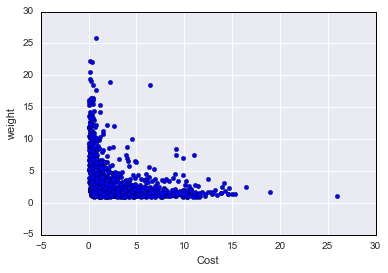

In [335]:
pos_index=[i for (i,x) in enumerate(ytrain_data) if x>0 ]
#pos_index=[i for (i,x) in enumerate(test) if x>0 ]
weight_pos=xtrain_data['var11'][pos_index]
sign_pos=ytrain_data[pos_index]
unit_scale=max(weight_pos)/max(sign_pos)
weight_scaled=weight_pos*sign_pos
plt.scatter(sign_pos,weight_pos/unit_scale)
#plt.hist(weight_scaled/unit_scale,bins=50)
plt.xlabel('Cost')
plt.ylabel('weight')

In [8]:
test_data.shape

(1000, 69)

In [336]:
features_name=xtrain_data.columns
num_features=xtrain_data.shape[1]
print ('number total features={}'.format(num_features))
xtrain_data.head(10)

number total features=69


,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,weahter_trim43,weahter_trim44,weahter_trim45,weahter_trim46,weahter_trim47,weahter_trim48,pca_geo1,pca_geo2,pca_crime1,pca_crime2
0,Z,Z,Z,N1,Z,Z,3,1,A,3.898949,...,0.087160,0.834392,0.000000,1.488921,1.215303,0.112556,-0.851407,0.236054,-9.877135e-02,-3.076164e-01
1,Z,Z,Z,C1,Z,Z,3,2,A,3.898949,...,0.087160,0.955027,0.001751,0.271985,1.036739,0.033052,-0.774846,0.057575,-7.990080e-02,-3.345901e-01
2,3,Z,4,J3,B,B,2,4,Z,4.314082,...,0.615548,0.975133,0.003501,3.014886,1.076535,0.566352,0.012889,-0.041014,4.100035e-01,1.970156e-01
3,3,Z,4,H1,B,Z,3,4,Z,4.314082,...,0.615548,0.924869,0.000175,1.316712,0.340631,0.290147,0.414365,0.046461,2.284997e-01,3.213033e-01
4,Z,Z,Z,H1,Z,Z,2,4,A,3.898949,...,4.425052,1.196297,7.193384,1.629389,1.016120,1.313732,-0.264987,0.017974,2.049395e-01,1.430427e-01
5,Z,Z,Z,A1,Z,Z,4,2,A,3.824453,...,0.922684,1.115874,1.295495,0.794668,1.010759,1.173893,0.371219,0.374754,2.294233e-01,-4.448948e-02
6,Z,Z,Z,H2,Z,Z,3,3,A,3.898949,...,0.479860,1.135980,0.000058,0.086500,1.135300,0.789888,0.550118,-0.234879,-4.334570e-13,-3.399755e-13
7,Z,Z,Z,E3,Z,Z,3,3,A,4.171214,...,0.920062,0.993951,1.043171,0.001166,0.886631,0.003998,0.312152,-0.256252,7.984971e-01,-1.958333e-01
8,Z,Z,Z,M1,Z,Z,3,1,B,4.039930,...,0.786037,1.075662,0.000992,3.933963,1.129114,2.222157,0.194191,-0.054439,-3.418484e-02,1.571250e-01
9,Z,Z,Z,R3,Z,Z,3,1,A,4.039930,...,0.087160,0.894710,0.000000,0.300868,1.228087,0.037004,-3.454792,-0.177641,-9.877135e-02,-3.076164e-01


In [337]:
#num_fire=len([ytrain_data>0])
num_fire=len(pos_index)
print ('True signal percentage= {}'.format(1.0*num_fire/num_train))

True signal percentage= 0.00262796392522


In [338]:
num_miss_col=np.sum(xtrain_data.isnull())
num_miss_row=np.sum(xtrain_data.isnull().any(axis=1))
print ('number of missing col={}'.format(num_miss_col))
print ('number of missing row={}'.format(num_miss_row))

number of missing col=var1                   0
var2                   0
var3                   0
var4                   0
var5                   0
var6                   0
var7                   0
var8                   0
var9                   0
var10                  0
var11                  0
var12             355042
var13                  0
var14             290466
var15              98856
var16             361693
var17                  0
weahter_trim1          0
weahter_trim2          0
weahter_trim3          0
weahter_trim4          0
weahter_trim5          0
weahter_trim6          0
weahter_trim7          0
weahter_trim8          0
weahter_trim9          0
weahter_trim10         0
weahter_trim11         0
weahter_trim12         0
weahter_trim13         0
                   ...  
weahter_trim23         0
weahter_trim24         0
weahter_trim25         0
weahter_trim26         0
weahter_trim27         0
weahter_trim28         0
weahter_trim29         0
weahter_trim30         0
wea

In [339]:
test_data.shape

(450728, 69)

In [340]:
# fill NA with Mean
float_feaature_list=[]
for (i,x) in enumerate(features_name):
    if (xtrain_data[x].dtype==float):
        float_feaature_list.append(i)
        xtrain_data[x].fillna(xtrain_data[x].mean(),inplace=True)
        test_data[x].fillna(test_data[x].mean(),inplace=True)
float_feaature_name=features_name[float_feaature_list]

In [14]:
float_feaature_name

Index([u'var10', u'var11', u'var12', u'var13', u'var14', u'var15', u'var16',
       u'var17', u'weahter_trim1', u'weahter_trim2', u'weahter_trim3',
       u'weahter_trim4', u'weahter_trim5', u'weahter_trim6', u'weahter_trim7',
       u'weahter_trim8', u'weahter_trim9', u'weahter_trim10',
       u'weahter_trim11', u'weahter_trim12', u'weahter_trim13',
       u'weahter_trim14', u'weahter_trim15', u'weahter_trim16',
       u'weahter_trim17', u'weahter_trim18', u'weahter_trim19',
       u'weahter_trim20', u'weahter_trim21', u'weahter_trim22',
       u'weahter_trim23', u'weahter_trim24', u'weahter_trim25',
       u'weahter_trim26', u'weahter_trim27', u'weahter_trim28',
       u'weahter_trim29', u'weahter_trim30', u'weahter_trim31',
       u'weahter_trim32', u'weahter_trim33', u'weahter_trim34',
       u'weahter_trim35', u'weahter_trim36', u'weahter_trim37',
       u'weahter_trim38', u'weahter_trim39', u'weahter_trim40',
       u'weahter_trim41', u'weahter_trim42', u'weahter_trim43',
       

######  ordinal feature: fill missing with median; convert to  float

In [341]:
ord_feature=['var1', 'var3', 'var7', 'var8']
for feature in ord_feature:
    xtrain_data[feature]=xtrain_data[feature].replace('Z',np.nan)
    test_data[feature]=test_data[feature].replace('Z',np.nan)
for feature in ord_feature:
    med=xtrain_data[feature].astype(float).median()
    xtrain_data[feature]=xtrain_data[feature].replace(np.nan,med)
    med1=test_data[feature].astype(float).median()
    test_data[feature]=test_data[feature].replace(np.nan,med1)
for feature in ord_feature:
    xtrain_data[feature]=xtrain_data[feature].astype(float)        
    test_data[feature]=test_data[feature].astype(float)    

##### nominal data type

In [342]:
nominal_feature=['var2', 'var4', 'var5', 'var6','var9']
for feature in nominal_feature:
    tmp_feature=pd.get_dummies(xtrain_data[feature],prefix=feature)
    xtrain_data = pd.concat([xtrain_data, tmp_feature], axis=1)
    tmp_feature1=pd.get_dummies(test_data[feature],prefix=feature)
    test_data = pd.concat([test_data, tmp_feature1], axis=1)
# for feature in nominal_feature:
#     xtrain_data[feature]=xtrain_data[feature].astype('category')
#category_data=xtrain_data[nominal_feature].T.to_dict().values()

In [343]:
weight_train=xtrain_data['var11']
xtrain_data=xtrain_data.drop(nominal_feature+['var11'],axis=1)
test_data=test_data.drop(nominal_feature+['var11'],axis=1)

In [35]:
xtrain_data.columns

Index([u'var1', u'var3', u'var7', u'var8', u'var10', u'var12', u'var13',
       u'var14', u'var15', u'var16',
       ...
       u'var5_E', u'var5_F', u'var5_Z', u'var6_A', u'var6_B', u'var6_C',
       u'var6_Z', u'var9_A', u'var9_B', u'var9_Z'],
      dtype='object', length=124)

In [17]:
xtrain_data.head(10)

,var1,var3,var7,var8,var10,var12,var13,var14,var15,var16,...,var5_E,var5_F,var5_Z,var6_A,var6_B,var6_C,var6_Z,var9_A,var9_B,var9_Z
0,3,3,3,1,3.898949,3.099522,0.000000,0.000000,29.000000,73.423978,...,0,0,1,0,0,0,1,1,0,0
1,3,3,3,2,3.898949,3.099522,1.268636,0.224294,23.000000,73.423978,...,0,0,1,0,0,0,1,1,0,0
2,3,4,2,4,4.314082,2.719846,2.482178,0.000000,31.190926,100.000000,...,0,0,0,0,1,0,0,0,0,1
3,3,4,3,4,4.314082,3.520478,2.054144,0.000000,22.000000,100.000000,...,0,0,0,0,0,0,1,0,0,1
4,3,3,2,4,3.898949,3.099522,0.832555,0.224294,21.000000,73.423978,...,0,0,1,0,0,0,1,1,0,0
5,3,3,4,2,3.824453,3.099522,1.268636,0.000000,11.000000,73.423978,...,0,0,1,0,0,0,1,1,0,0
6,3,3,3,3,3.898949,3.099522,0.832555,0.224294,17.000000,73.423978,...,0,0,1,0,0,0,1,1,0,0
7,3,3,3,3,4.171214,3.099522,1.835019,0.224294,28.000000,73.423978,...,0,0,1,0,0,0,1,1,0,0
8,3,3,3,1,4.039930,3.099522,1.268636,0.000000,44.000000,73.423978,...,0,0,1,0,0,0,1,0,1,0
9,3,3,3,1,4.039930,3.099522,1.177410,0.224294,26.000000,73.423978,...,0,0,1,0,0,0,1,1,0,0


###### removed  the following complared with Version I

In [ ]:
# from sklearn.feature_extraction import DictVectorizer as DV
# vectorizer = DV( sparse = False )
# vec_x_train = vectorizer.fit_transform(category_data)
# #xtrain_data = np.hstack(( xtrain_data.as_matrix(), vec_x_train ))

In [18]:
float_feaature_name[0:10]

Index([u'var10', u'var11', u'var12', u'var13', u'var14', u'var15', u'var16',
       u'var17', u'weahter_trim1', u'weahter_trim2'],
      dtype='object')

###### data split

In [353]:
weather_names=[]
weather_list=[]
geo_names=[]
geo_list=[]
crime_names=[]
crime_list=[]
for (i,x) in enumerate(features_name):
    if (re.search('^wea',x)!=None):
        weather_names.append(x)
        weather_list.append(i)
    if (re.search('^geo',x)!=None):
        geo_names.append(x)
        geo_list.append(i)
    if (re.search('^cri',x)!=None):
        crime_names.append(x)
        crime_list.append(i)
weather_data=xtrain_data[weather_list]
crime_data=xtrain_data[crime_list]
geo_data=xtrain_data[geo_list]

###### drop waether feature

In [357]:
xtrain_data=xtrain_data.drop(weather_names,axis=1)
test_data=test_data.drop(weather_names,axis=1)

In [355]:
weather_list

[17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64]

In [34]:
xtrain_data.iloc[1:20,1:25]

,var3,var7,var8,var10,var12,var13,var14,var15,var16,var17,...,weahter_trim5,weahter_trim6,weahter_trim7,weahter_trim8,weahter_trim9,weahter_trim10,weahter_trim11,weahter_trim12,weahter_trim13,weahter_trim14
1,4,3,2,3.898949,3.091085,1.048147,0.000000,35.000000,72.2,96.052632,...,1.296677,0.974747,0.000000,0.000000,0.000000,0,1.266950,0.000000,0.675758,0.521257
2,4,3,3,3.898949,3.091085,0.000000,0.217706,60.000000,72.2,87.394958,...,0.931164,1.022362,0.221210,8.355505,0.273682,0,0.907541,0.363566,1.044470,0.432717
3,3,2,4,4.509069,3.390092,1.715937,0.000000,31.273072,100.0,54.545455,...,1.122566,1.007545,3.093851,0.000000,0.000000,0,1.144677,0.000000,0.693868,1.012189
4,4,2,6,4.171214,3.091085,0.832555,0.217706,59.000000,72.2,98.185793,...,0.970858,1.020395,0.344478,0.000000,0.347546,0,0.963638,4.332633,1.027289,0.538707
5,4,7,2,4.314082,3.091085,1.987774,0.217706,55.000000,72.2,100.000000,...,0.897626,1.000200,0.779490,0.000000,0.659789,0,0.908402,0.000000,1.279621,0.893675
6,4,3,2,3.898949,3.091085,0.000000,0.000000,42.000000,72.2,71.602825,...,0.912588,1.017430,0.668261,0.000000,0.004589,0,0.898749,0.000000,0.952733,0.266728
7,4,4,1,3.898949,3.091085,0.000000,0.217706,31.273072,72.2,100.000000,...,0.892570,1.017314,0.000000,0.000000,0.145380,0,0.853079,0.868094,1.078555,0.617361
8,4,3,2,4.314082,3.218098,2.131501,0.000000,30.000000,100.0,100.000000,...,1.157714,0.998098,0.792560,0.000000,0.000000,0,1.095240,0.615254,0.462838,1.006683
9,4,4,1,5.123351,2.934707,2.580809,0.000000,10.000000,0.0,74.498918,...,0.944803,0.998633,0.818408,0.000000,0.384523,0,0.972141,0.000000,1.212933,0.906376
10,4,7,4,4.509069,3.091085,2.382594,0.832555,31.273072,100.0,0.000000,...,0.948368,1.020957,0.083309,18.508230,0.274150,0,0.934896,1.817273,1.010667,0.448302


In [17]:
geo_data.head(2)

""
0
1


In [18]:
crime_data.head(2)

""
0
1


In [19]:
weather_data.head(2)

,weahter_trim1,weahter_trim2,weahter_trim3,weahter_trim4,weahter_trim5,weahter_trim6,weahter_trim7,weahter_trim8,weahter_trim9,weahter_trim10,...,weahter_trim39,weahter_trim40,weahter_trim41,weahter_trim42,weahter_trim43,weahter_trim44,weahter_trim45,weahter_trim46,weahter_trim47,weahter_trim48
0,0,1.129245,0,1.192119,1.106395,1.011848,0.424069,0,0,0,...,1.071992,0.985773,1.090829,1.016216,0.087160,0.894710,0.000000,0.300868,1.228087,0.037004
1,0,1.310436,0,19.285895,1.296677,0.974747,0.000000,0,0,0,...,1.171250,1.200395,1.171352,1.093474,0.125472,1.045504,19.271952,1.617166,1.201075,0.152336


In [35]:
xtrain_num_data.head(3)

,var10,var11,var12,var13,var14,var15,var16,var17,weahter_trim1,weahter_trim2,...,weahter_trim43,weahter_trim44,weahter_trim45,weahter_trim46,weahter_trim47,weahter_trim48,pca_geo1,pca_geo2,pca_crime1,pca_crime2
0,4.039930,1492.246628,3.091271,1.177410,0.225342,26,73.67616,100.000000,0.000000,1.129245,...,0.087160,0.894710,0.000000,0.300868,1.228087,0.037004,-3.454792,-0.177641,-0.098771,-0.307616
1,3.898949,616.441400,3.091271,1.048147,0.000000,35,73.67616,96.052632,0.000000,1.310436,...,0.125472,1.045504,19.271952,1.617166,1.201075,0.152336,-1.043316,-0.073276,0.152420,-0.004554
2,3.898949,609.327498,3.091271,0.000000,0.225342,60,73.67616,87.394958,3.076415,0.949404,...,0.622892,0.965080,0.000058,0.225651,1.129320,0.615880,-0.098136,0.326503,-0.450910,-0.133991


###### collreation study, not used for train

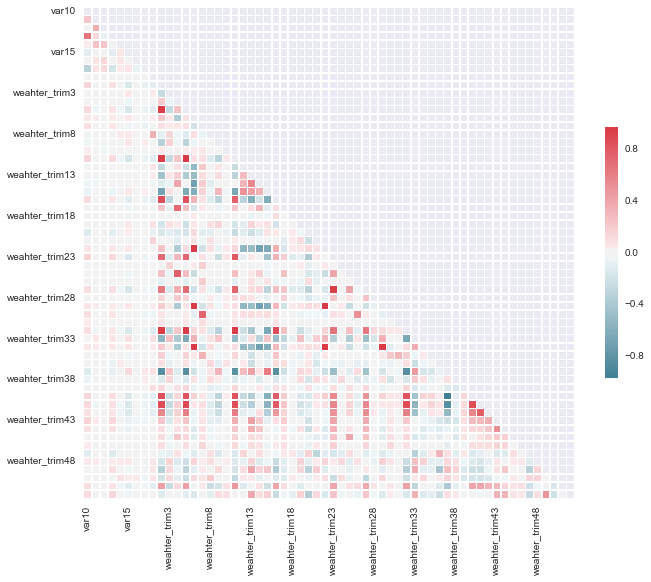

In [44]:
#xtrain_data.corr()
xtrain_num_data=xtrain_data[float_feaature_list]
xtrain_num_data=xtrain_num_data/np.std(xtrain_num_data)
corr= xtrain_num_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.linewidth']=1
# sns.graphics.plot_corr(corr_matrix, xnames=xtrain_data.names)
# plt.show()

# data train

In [358]:
import sklearn
import sklearn.cross_validation
from sklearn.linear_model import LogisticRegression
#ytrain=ytrain_data.as_matrix()
ytrain= np.asarray(ytrain_data,dtype="float")
ytrain[ytrain>0]=1
#ytrain=list(ytrain_data.values)
np.random.seed(1337)
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split( \
       xtrain_data, ytrain)

In [345]:
ixx=list(X_train.index)
weight_sub_train=weight_train[ixx]
ixx=list(X_test.index)
weight_sub_test=weight_train[ixx]

In [20]:
# y_train=np.asarray(y_train)

In [38]:
import sklearn.metrics
import time
def evaluate_model(clf):
    """Scores a model using log loss with the created train and test sets."""
    start = time.time()
    clf.fit(X_train, y_train)
    print ("Train score:", sklearn.metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    print ("Test score:", sklearn.metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    print ("Total time:", time.time() - start)

In [125]:
from __future__ import division
import pandas as pd
import numpy as np

def weighted_gini(act,pred,weight):
    df = pd.DataFrame({"act":act,"pred":pred,"weight":weight})
    df = df.sort_values('pred',ascending=False)
    df["random"] = (df.weight / df.weight.sum()).cumsum()
    total_pos = (df.act * df.weight).sum()
    df["cum_pos_found"] = (df.act * df.weight).cumsum()
    df["lorentz"] = df.cum_pos_found / total_pos
    n = df.shape[0]
#df["gini"] = (df.lorentz - df.random) * df.weight
#return df.gini.sum()
    gini = sum(df.lorentz[1:].values * (df.random[:-1])) - sum(df.lorentz[:-1].values * (df.random[1:]))
    return gini
def normalized_weighted_gini(act,pred,weight):
    return weighted_gini(act,pred,weight) / weighted_gini(act,act,weight)

def weighted_gini_line(act,pred,weight):
    df = pd.DataFrame({"act":act,"pred":pred,"weight":weight})
    df = df.sort_values('pred',ascending=False)
    df["random"] = (df.weight / df.weight.sum()).cumsum()
    total_pos = (df.act * df.weight).sum()
    df["cum_pos_found"] = (df.act * df.weight).cumsum()
    df["lorentz"] = df.cum_pos_found / total_pos
    n = df.shape[0]
#df["gini"] = (df.lorentz - df.random) * df.weight
#return df.gini.sum()
    df["gini"] = (df.lorentz[1:].values * (df.random[:-1])) - (df.lorentz[:-1].values * (df.random[1:]))
    return (df)


In [40]:
##test only
var11=[1, 2, 5, 4, 3]
pred=[0.1, 0.4, 0.3, 1.2, 0.0]
target=[0, 0, 1, 0, 1]
weighted_gini(target,pred,var11)
normalized_weighted_gini(target,pred,var11)
#-0.82142857142857195

-0.82142857142857195

###### matlab version

In [41]:
# function gini = weighted_gini(act,pred,weight)

# [~, I] = sort(pred);
# weight = weight(I);
# act = act(I);

# drandom = cumsum(weight);
# drandom = drandom / drandom(end);
# lorentz = cumsum(act.*weight);
# lorentz = lorentz / lorentz(end);

# gini = sum(lorentz(2:end).*drandom(1:end-1)) - sum(lorentz(1:end-1).*drandom(2:end));


# function f = normalized_weighted_gini(act,pred,weight)
# f = weighted_gini(act,pred,weight) / weighted_gini(act,act,weight);

In [42]:
def compare_listcomp(x, y):
    return [1 for i, j in zip(x, y) if i == j]

import pylab as pl
import sklearn.metrics as skm
import math
def summary_model(clf):
    test_pred=clf.predict(X_test)
    train_pred=clf.predict(X_train)
    accuracy_test=1.0*sum(compare_listcomp(test_pred,y_test))/len(y_test)
    accuracy_train=1.0*sum(compare_listcomp(train_pred,y_train))/len(y_train)
    print("prediction accuaracy on the trainning data= %f" %(accuracy_train))
    print("prediction accuaracy on the test      data= %f" %(accuracy_test))
    print("mean accuracy score for validation set = %f" %(clf.score(X_train, y_train)))
    print("mean accuracy score for test set = %f" %(clf.score(X_test, y_test)))
    test_cm = skm.confusion_matrix(y_test,test_pred)
    pl.matshow(test_cm)
    pl.title('Confusion matrix for test data')
    pl.colorbar()
    pl.show()
    print('confusing table,\n')
    print(test_cm)
    test_truth=y_test
    # Accuracy
    print("Accuracy = %f" %(clf.accuracy_score(test_truth,test_pred)))
    # Precision
    print("Precision = %f" %(clf.precision_score(test_truth,test_pred)))
    # Recall
    print("Recall = %f" %(clf.recall_score(test_truth,test_pred)))
    # F1 Score
    print("F1 score = %f" %(clf.f1_score(test_truth,test_pred)))

In [43]:
test_data.head(10)

,var1,var3,var7,var8,var10,var12,var13,var14,var15,var16,...,var5_E,var5_F,var5_Z,var6_A,var6_B,var6_C,var6_Z,var9_A,var9_B,var9_Z
0,3,4,3,3,4.509069,3.316941,0.832555,0.000000,31.000000,100.000000,...,0,0,1,0,0,0,1,0,0,1
1,3,4,7,4,4.039930,3.105055,1.700109,0.212364,37.000000,76.671795,...,0,0,1,0,0,0,1,1,0,0
2,3,4,4,1,3.898949,3.105055,0.000000,0.212364,30.000000,76.671795,...,0,0,1,0,0,0,1,1,0,0
3,3,4,7,3,4.039930,3.105055,0.000000,0.212364,15.000000,76.671795,...,0,0,1,0,0,0,1,1,0,0
4,4,4,5,1,4.314082,3.083709,1.869895,0.000000,20.000000,100.000000,...,0,0,0,0,0,0,1,0,0,1
5,3,4,5,2,4.314082,3.105055,2.104951,0.212364,30.777222,76.671795,...,0,0,1,0,0,0,1,1,0,0
6,3,4,5,3,3.824453,3.105055,1.338566,0.212364,10.000000,76.671795,...,0,0,1,0,0,0,1,1,0,0
7,2,6,5,4,4.509069,3.264546,1.338566,0.000000,23.000000,100.000000,...,0,0,0,0,0,1,0,0,0,1
8,3,4,5,6,4.039930,3.105055,2.270086,0.212364,42.000000,76.671795,...,0,0,1,0,0,0,1,1,0,0
9,3,4,3,1,4.039930,3.105055,0.832555,0.212364,127.000000,76.671795,...,0,0,1,0,0,0,1,0,1,0



##### Save model and predicted to file for submission ONLY

In [359]:
    folds = 5 
    param = {}
    param['silent'] = 1
    param['nthread'] = 1
    param['eval_metric'] = 'auc' #'rmse'
# param['bst:max_depth'] = 6
# param['min_child_weight']=1
# param['gamma']=0
# param['subsample']=1    # = c(0.5, 0.75, 1),
# param['colsample_bytree']=0.9  # = c(0.6, 0.8, 1))
# param['learning_rate']=0.2
    param['objective'] ='binary:logistic'  #binary:logitraw'  
    param['bst:max_depth'] = 1
    param['min_child_weight']=1
    param['gamma']=0
    param['subsample']=1    # = c(0.5, 0.75, 1),
    param['colsample_bytree']=0.9  # = c(0.6, 0.8, 1))
    param['learning_rate']=0.1
    num_round=40
    sum_wpos = sum( weight_train[i] for i in range(len(ytrain)) if ytrain[i] > 0.0  )
    sum_wneg = sum( weight_train[i] for i in range(len(ytrain)) if ytrain[i] == 0.0  )    
    if (sum_wneg>  sum_wpos*100000):
        sum_wpos=1000*sum_wneg
    param['scale_pos_weight'] = sum_wneg / sum_wpos
    plst = param.items()#+[('eval_metric', 'ams@0.15')]

    xgmat = xgb.DMatrix(xtrain_data, label=ytrain, weight=weight_train)
    watchlist =[(xgmat, 'train')]
    
    bst_best_model= xgb.train(plst, xgmat, num_round, watchlist)
    print('model fit done')
    # save out model
    bst_best_model.save_model('best.model')
    xgmat_test = xgb.DMatrix(test_data)
    pred = bst_best_model.predict(xgmat_test)
## new dataframe fro submission
    data_test_sub=pd.DataFrame({"id":test_data.index,"target":pred})
    data_test_sub.to_csv('submission40nowe.csv',index=False)

[0]	train-auc:0.71355
[1]	train-auc:0.747516
[2]	train-auc:0.752305
[3]	train-auc:0.766992
[4]	train-auc:0.777659
[5]	train-auc:0.788232
[6]	train-auc:0.791983
[7]	train-auc:0.794818
[8]	train-auc:0.799522
[9]	train-auc:0.803628
[10]	train-auc:0.81288
[11]	train-auc:0.8184
[12]	train-auc:0.82241
[13]	train-auc:0.825871
[14]	train-auc:0.830444
[15]	train-auc:0.836463
[16]	train-auc:0.83731
[17]	train-auc:0.84076
[18]	train-auc:0.845426
[19]	train-auc:0.84615
[20]	train-auc:0.854856
[21]	train-auc:0.856354
[22]	train-auc:0.857575
[23]	train-auc:0.859186
[24]	train-auc:0.860369
[25]	train-auc:0.863758
[26]	train-auc:0.865105
[27]	train-auc:0.866038
[28]	train-auc:0.866526
[29]	train-auc:0.87085
[30]	train-auc:0.872747
[31]	train-auc:0.877303
[32]	train-auc:0.877467
[33]	train-auc:0.877362
[34]	train-auc:0.879315
[35]	train-auc:0.879447
[36]	train-auc:0.880061
[37]	train-auc:0.880943
[38]	train-auc:0.881033
[39]	train-auc:0.882973
model fit done


##### feather importance

gini score of whole training data=0.765944156656


(array([  5.90000000e+01,   1.10400000e+03,   3.39400000e+03,
          5.85800000e+03,   6.79000000e+03,   6.83700000e+03,
          6.44300000e+03,   6.14400000e+03,   5.52700000e+03,
          5.10300000e+03,   5.04400000e+03,   4.78100000e+03,
          4.60200000e+03,   4.33200000e+03,   4.13400000e+03,
          4.18900000e+03,   4.30800000e+03,   5.06800000e+03,
          5.21200000e+03,   5.08900000e+03,   5.20100000e+03,
          4.95300000e+03,   5.17700000e+03,   4.65700000e+03,
          4.79200000e+03,   4.87900000e+03,   4.67600000e+03,
          4.67800000e+03,   5.11100000e+03,   6.07900000e+03,
          6.21600000e+03,   5.90900000e+03,   5.46500000e+03,
          5.52500000e+03,   5.58200000e+03,   5.61500000e+03,
          6.30100000e+03,   6.76700000e+03,   7.05900000e+03,
          7.25200000e+03,   7.41400000e+03,   7.66700000e+03,
          8.14700000e+03,   9.04700000e+03,   8.65400000e+03,
          9.18100000e+03,   9.43500000e+03,   1.04650000e+04,
        

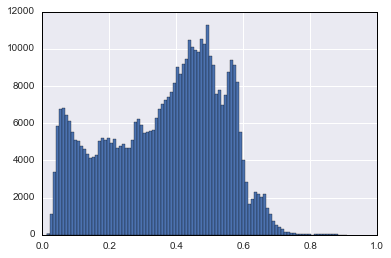

In [360]:
y_out=bst_best_model.predict(xgmat)
num=ytrain.shape[0]
ytrain=np.reshape(ytrain,num)
y_out=np.reshape(y_out,num)
gini_score=normalized_weighted_gini(ytrain,y_out,weight_train)
print('gini score of whole training data={}'.format(gini_score))

#plt.hist(pred,bins=50)
plt.hist(y_out,bins=100)

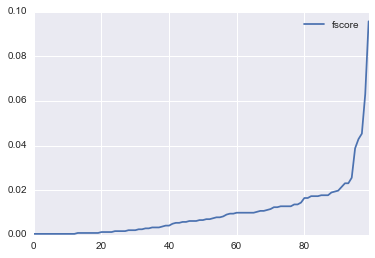

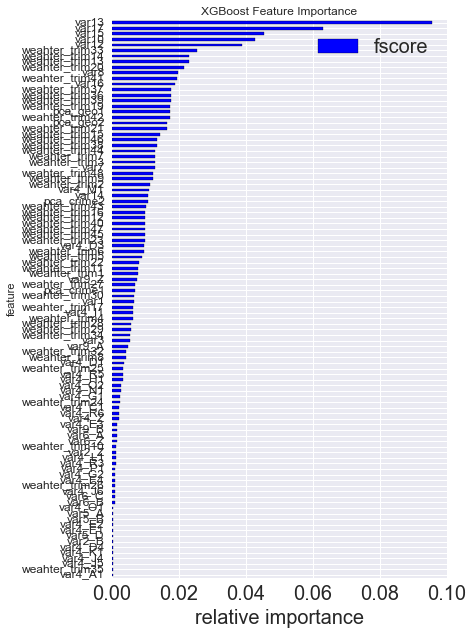

In [122]:
import operator
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

features = list(xtrain_data.columns)
ceate_feature_map(features)
importance =bst_best_model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

fig = plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance',fontsize=20)
fig.set_size_inches(10,12) 
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.gcf().savefig('feature_importance_xgb2.png')



In [180]:
df_importance = df.sort_values('fscore',ascending=False)
df_importance.to_csv('gbx_fscore.csv')
df_importance.head(30)

,feature,fscore
99,var13,0.095631
98,var17,0.063067
97,var15,0.045342
96,var10,0.042869
95,var12,0.038747
94,weahter_trim33,0.025556
93,weahter_trim14,0.023083
92,weahter_trim13,0.023083
91,weahter_trim20,0.021434
90,var8,0.019786


In [162]:
weight_pos is weight_train

False

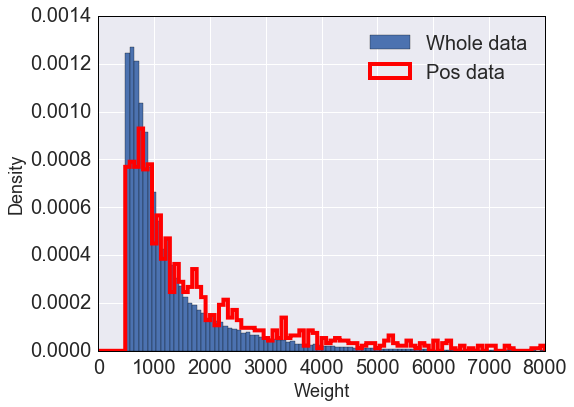

In [300]:
fig = plt.figure()
cof=9000/140
plt.hist(weight_train,bins=100,label='Whole data',normed=1,range=(0,8000))
plt.hist(weight_pos,bins=100,label='Pos data',normed=1,color='red',\
         range=(0,8000),histtype="step",linewidth=4)
plt.xlabel('Weight',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(8,6)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.linewidth']=1

fig.set_dpi(1240)
fig.savefig('weight.png', transparent=True, bbox_inches='tight', pad_inches=0)

In [253]:
def weighted_lorentz_line(act,pred,weight,pref):
    df = pd.DataFrame({"act":act,"pred":pred,"weight":weight})
    if perf==0:
        df = df.sort_values('pred',ascending=True)
    df["random"] = (df.weight / df.weight.sum()).cumsum()
    total_pos = (df.act * df.weight).sum()
    df["cum_pos_found"] = (df.act * df.weight).cumsum()
    df["lorentz"] = df.cum_pos_found / total_pos
    n = df.shape[0]
#df["gini"] = (df.lorentz - df.random) * df.weight
#return df.gini.sum()
    df["gini"] = (df.lorentz[1:].values * (df.random[:-1])) - (df.lorentz[:-1].values * (df.random[1:]))
    return (df)


###### Plot AUC plot

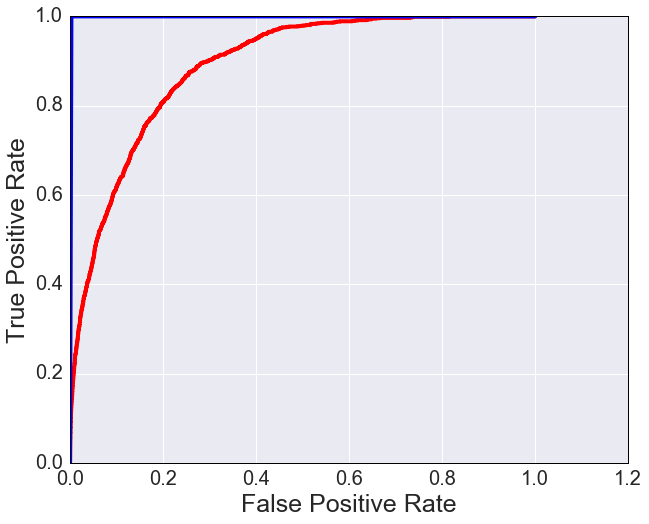

In [299]:
fig = plt.figure()
unit_weight=[1 for x in weight_train]
#sample_
lorentz0=weighted_gini_line(ytrain,y_out,unit_weight)
lorentzp=weighted_gini_line(ytrain,ytrain,unit_weight)
plt.plot(lorentz0.random,lorentz0.lorentz,linewidth=4,color='red')
plt.plot(lorentzp.random,lorentzp.lorentz,linewidth=4,color='blue')
#plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(10,8) 
plt.xlabel('False Positive Rate',fontsize=25)
plt.ylabel('True Positive Rate',fontsize=25)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.linewidth']=1

fig.set_dpi(1240)
fig.savefig('AUC.png', transparent=True, bbox_inches='tight', pad_inches=0)


In [290]:
print plt.rcParams['axes.edgecolor']
plt.rcParams['axes.edgecolor']='black'
print plt.rcParams['axes.edgecolor']
plt.rcParams

black
black


RcParams({u'agg.path.chunksize': 0,
          u'animation.avconv_args': [],
          u'animation.avconv_path': u'avconv',
          u'animation.bitrate': -1,
          u'animation.codec': u'mpeg4',
          u'animation.convert_args': [],
          u'animation.convert_path': u'convert',
          u'animation.ffmpeg_args': [],
          u'animation.ffmpeg_path': u'ffmpeg',
          u'animation.frame_format': u'png',
          u'animation.html': u'none',
          u'animation.mencoder_args': [],
          u'animation.mencoder_path': u'mencoder',
          u'animation.writer': u'ffmpeg',
          u'axes.axisbelow': True,
          u'axes.edgecolor': 'black',
          u'axes.facecolor': '#EAEAF2',
          u'axes.formatter.limits': [-7, 7],
          u'axes.formatter.use_locale': False,
          u'axes.formatter.use_mathtext': False,
          u'axes.formatter.useoffset': True,
          u'axes.grid': True,
          u'axes.grid.axis': u'both',
          u'axes.grid.which': u'major',

###### plot GINI plot

Populating the interactive namespace from numpy and matplotlib


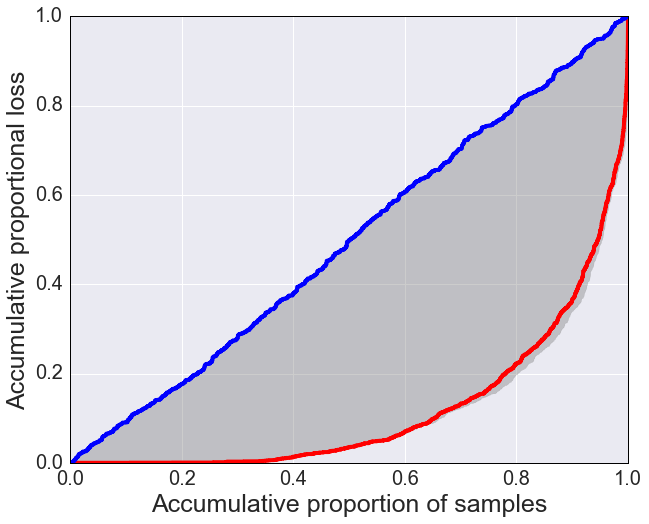

In [361]:
%pylab inline
fig = plt.figure()
unit_weight=[1 for x in weight_train]
perf=0
lorentz0=weighted_lorentz_line(ytrain,y_out,weight_train,perf)
perf=1
lorentzp=weighted_lorentz_line(ytrain,ytrain,weight_train,perf)
plt.plot(lorentz0.random,lorentz0.lorentz,linewidth=4,color='red')
plt.plot(lorentzp.random,lorentzp.lorentz,linewidth=4,color='blue')
#plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(10,8) 
plt.xlabel('Accumulative proportion of samples',fontsize=25)
plt.ylabel('Accumulative proportional loss',fontsize=25)
plt.xlim([0,1])
xx=np.concatenate([lorentzp.random, lorentzp.random[::-1]])
yy=np.concatenate([lorentz0.lorentz,lorentzp.lorentz[::-1]])
plt.fill(xx, yy, color='grey', alpha = 0.4)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.linewidth']=1
plt.axis('on')
fig.set_dpi(1240)
fig.savefig('GINI_xgb40_wo_wea.png', transparent=True, bbox_inches='tight', pad_inches=0)

RuntimeError: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' path

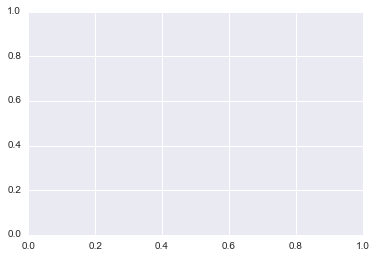

In [139]:
#from sklearn import plot_importance, plot_tree, to_graphviz
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image  
xgb.plot_tree(bst_best_model,10)
xgb.to_graphvi(bst_best_model,10)

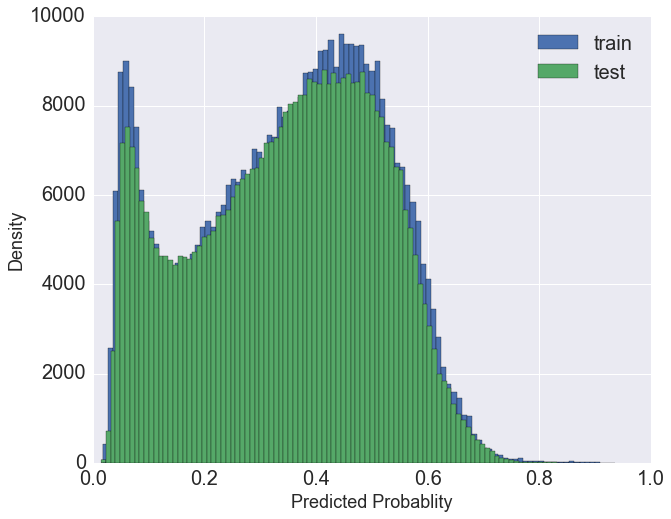

In [86]:

fig = plt.figure()
plt.hist(y_out,bins=100,label='train')
plt.hist(pred,bins=100,label='test')
plt.xlabel('Predicted Probablity',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(10,8) 
fig.set_dpi(1240)
fig.savefig('predlog.png', transparent=True, bbox_inches='tight', pad_inches=0)

In [58]:
threshold=0.60
pred[pred>threshold]=1
pred[pred<threshold]=0    
data_test_sub=pd.DataFrame({"id":test_data.index,"target":pred})
data_test_sub.to_csv('submission4.csv',index=False)
data_test_sub.shape

(450728, 2)

(452061, 124)
(1000, 118)
0.4


(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.   ,  0.024,  0.048,  0.072,  0.096,  0.12 ,  0.144,  0.168,
         0.192,  0.216,  0.24 ,  0.264,  0.288,  0.312,  0.336,  0.36 ,
         0.384,  0.408,  0.432,  0.456,  0.48 ,  0.504,  0.528,  0.552,
         0.576,  0.6  ,  0.624,  0.648,  0.672,  0.696,  0.72 ,  0.744,
         0.768,  0.792,  0.816,  0.84 ,  0.864,  0.888,  0.912,  0.936,
         0.96 ,  0.984,  1.008,  1.032,  1.056,  1.08 ,  1.104,  1.128,
         1.152,  1.176,  1.2  ]),
 <a list of 50 Patch objects>)

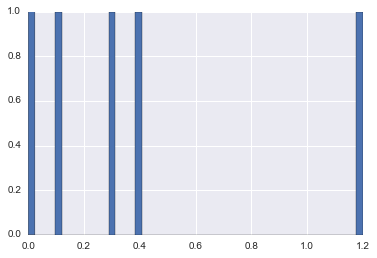

In [29]:
print xtrain_data.shape
print test_data.shape
print sum(pred)/len(pred)
plt.hist(pred,bins=50)
#True signal percentage= 0.00262796392522

In [51]:
max(y_train)

15.036643570000001

## LogisticRegression

('Train score:', 0.70182292162221238)
('Test score:', 0.69746010602521091)
('Total time:', 116.31500005722046)
prediction accuaracy on the trainning data= 0.997410
prediction accuaracy on the test      data= 0.997257
mean accuracy score for validation set = 0.997410
mean accuracy score for test set = 0.997257


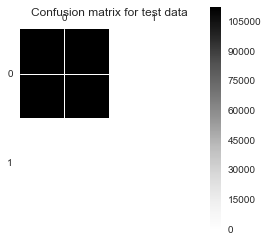

confusing table,

[[112706      0]
 [   310      0]]


AttributeError: 'LogisticRegression' object has no attribute 'accuracy_score'

In [57]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
evaluate_model(logit)
logit.fit(X_train,y_train)
summary_model(logit)

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline([('scale', MinMaxScaler()), ('classifier', LogisticRegression())])
evaluate_model(pipe)


('Train score:', 0.69810067188366642)
('Test score:', 0.69967590528139723)
('Total time:', 15.29800009727478)


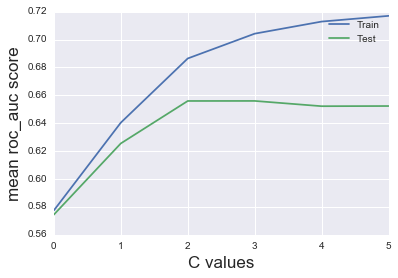

In [274]:
# evaluate for varying values of C. Plot training curves
import sklearn.learning_curve
import matplotlib.pyplot as plt
C_values =[1e-3,1e-2,1e-1,1,10,100] # fill in values
#C_values =[0.1,0.4,1, 10, 20] # fill in values

train_scores, test_scores = sklearn.learning_curve.validation_curve(
     pipe, X_train, y_train, 'classifier__C', C_values, scoring='roc_auc')
plt.plot(np.mean(train_scores, axis=1), label='Train')
plt.plot(np.mean(test_scores, axis=1), label='Test')
plt.xlabel('C values',fontsize=17)
plt.ylabel('mean roc_auc score',fontsize=17)
plt.legend(['Train','Test'])
plt.gcf().savefig('C_scan_gb1.png')

In [ ]:
print ok

In [45]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train,y_train)
y_out = ols.predict(X_test)
ols.intercept_

-62229557.746630855

In [46]:
num=y_test.shape[0]
y_test=np.reshape(y_test,num)
y_out=np.reshape(y_out,num)
gini_score=normalized_weighted_gini(y_test,y_out,weight_sub_test)
print('gini score={}'.format(gini_score))
summary_model(ols)

gini score=0.376927077452
prediction accuaracy on the trainning data= 0.000000
prediction accuaracy on the test      data= 0.000000
mean accuracy score for validation set = 0.000835
mean accuracy score for test set = 0.000397


ValueError: continuous is not supported

(array([  1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          5.00000000e+00,   4.00000000e+00,   4.00000000e+00,
          4.00000000e+00,   7.00000000e+00,   4.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   4.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          3.00000000e+00,   7.00000000e+00,   1.40000000e+01,
          1.60000000e+01,   2.10000000e+01,   4.00000000e+01,
          7.20000000e+01,   1.23000000e+02,   1.76000000e+02,
          2.87000000e+02,   4.09000000e+02,   6.18000000e+02,
          9.24000000e+02,   1.35500000e+03,   2.00400000e+03,
          2.34000000e+03,   2.94800000e+03,   3.69200000e+03,
        

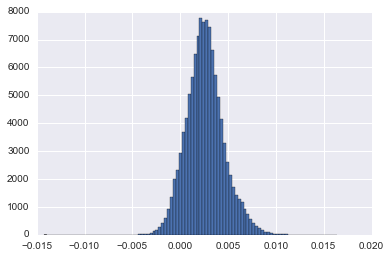

In [70]:
plt.hist(y_out,bins=100)
#plt.hist(y_train,bins=100)

In [74]:
max(y_train)

1.0

# RandomForest

In [77]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=3, n_jobs=7, )
rf.fit(xtrain_data,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=7,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [78]:
y_out=rf.predict_proba(xtrain_data)

([array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.000000

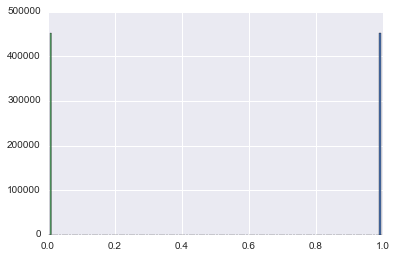

In [80]:
plt.hist(y_out,bins=100)

In [52]:
y_out[1]

array([ 0.99750869,  0.00249131])

In [318]:
folds = 5
param = {}
param['objective'] ='reg:logistic'  # 'reg:logistic' # 'binary:logitraw' 
param['silent'] = 1
param['nthread'] = 1
param['eval_metric'] = 'auc' #'rmse'
param['bst:max_depth'] = 6
param['min_child_weight']=1
param['gamma']=0
param['subsample']=1    # = c(0.5, 0.75, 1),
param['colsample_bytree']=0.9  # = c(0.6, 0.8, 1))
param['learning_rate']=0.1
weights=np.asarray(weight_train)
num_round = 100 # Number of boosted trees
#estimate_performance_xgboost(xtrain_data, ytrain,weights, param, num_round, folds)

In [362]:
    param['objective'] ='binary:logitraw'  
    param['max_depth'] = 3
    param['min_child_weight']=1
    param['gamma']=0
    param['subsample']=1    # = c(0.5, 0.75, 1),
    param['colsample_bytree']=0.9  # = c(0.6, 0.8, 1))
    param['learning_rate']=0.1
    num_round=70

In [79]:
params = {"objective": "reg:linear", "booster":"gblinear"}
# gbm.get_dump()


In [47]:
from sklearn.ensemble import GradientBoostingClassifier

gbt = GradientBoostingClassifier(n_estimators=10)
evaluate_model(gbt)

ValueError: Unknown label type: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

##### grid scan

In [324]:
    f=open("summary_bst_scan.txt","a")
    f.write('tuning parameters=')
    f.write('\n')
    for key, values in param.items():
        f.write('param {}={}'.format(key,values))
        f.write('\n')
    f.write('nfolds=%f' %(folds))
    f.write('\n')
    f.write('num_round=%f' %(num_round))
    f.write('\n')
    f.close()
    max_depth_values=[5,6]
    min_child_weight_values=[1,2,3,4,5]
    max_depth_values=[3]
    min_child_weight_values=[2]
    
    for x in max_depth_values:
        for y in min_child_weight_values:
            f=open("summary_bst_scan.txt","a")
            f.write('\n')
            f.write('-------------')
            f.write('\n')
            param['max_depth']=x
            param['min_child_weight']=y
            f.write('param {}={}'.format('max_depth',x))
            f.write('\n')
            f.write('param {}={}'.format('mini_child_weight',y))
            f.write('\n')
            f.write('--------------')
            f.write('\n')
            f.close()
#     gamma_vlaues=[10,100]
#     for x in gamma_vlaues:
#             f=open("summary_bst_scan.txt","a")
#             f.write('\n')
#             f.write('-------------')
#             f.write('\n')
#             param['gamma']=x
#             f.write('param {}={}'.format('gamma',x))
#             f.write('\n')
#             f.write('--------------')
#             f.write('\n')
#             f.close()
#     subsample_values=[0.6,0.8,0.9,1]
#     colsample_bytree_values=[0.6,0.8,0.9,1]
# #     subsample_values=[1]
# #     colsample_bytree_values=[0.5,0.7]
#     for x in subsample_values:
#         for y in colsample_bytree_values:
#             f=open("summary_bst_scan.txt","a")
#             f.write('\n')
#             f.write('-------------')
#             f.write('\n')
#             param['subsample']=x
#             param['colsample_bytree']=y
#             f.write('param {}={}'.format('subsample',x))
#             f.write('\n')
#             f.write('param {}={}'.format('colsample_bytree',y))
#             f.write('\n')
#             f.write('--------------')
#             f.write('\n')
#             f.close()
#     num_round_values =[150,180,200,250]
#     num_round_values =[100,120,130,140]
#     num_round_values =[60,70,80,90]
#     for x in num_round_values:
#             f=open("summary_bst_scan.txt","a")
#             f.write('\n')
#             f.write('-------------')
#             f.write('\n')
#             num_round =x
#             f.write('num_round={}'.format(x))
#             f.write('\n')
#             f.write('--------------')
#             f.write('\n')
#             f.close()

            estimate_performance_xgboost(xtrain_data, ytrain,weights, param, num_round, folds)
    

gini_score=0.327981685394
gini_score=0.227745492294
gini_score=0.360490837748
gini_score=0.252852996267
gini_score=0.295344383439
------------------------------------------------------
mean Gimi =0.292883079028 with std=0.0482785500169
Thresh = 0.0018
Accuracy = 0.9956: Precision = 0.0086, FP = 0.9914
Thresh = 0.0019
Accuracy = 0.9955: Precision = 0.0083, FP = 0.9917
Thresh = 0.0020
Accuracy = 0.9955: Precision = 0.0080, FP = 0.9920
Thresh = 0.0020
Accuracy = 0.9954: Precision = 0.0077, FP = 0.9923
Thresh = 0.0021
Accuracy = 0.9953: Precision = 0.0074, FP = 0.9926
Thresh = 0.0022
Accuracy = 0.9952: Precision = 0.0081, FP = 0.9919
Thresh = 0.0023
Accuracy = 0.9952: Precision = 0.0078, FP = 0.9922
Thresh = 0.0023
Accuracy = 0.9951: Precision = 0.0076, FP = 0.9924
Thresh = 0.0024
Accuracy = 0.9950: Precision = 0.0073, FP = 0.9927
Thresh = 0.0025
Accuracy = 0.9949: Precision = 0.0071, FP = 0.9929


In [322]:
def estimate_performance_xgboost(X,labels,weights, param, num_round, folds):
    '''
    Cross validation for XGBoost performance
    '''
    # Load training data
#     f=open("summary_bst_scan.txt","a")
#     X, labels, weights = get_training_data(training_file)
    f=open("summary_bst_scan.txt","a")
    start = np.random.random_integers(1000) #time.time()
    # Cross validate
    kf = cv.KFold(labels.size, n_folds=folds, random_state=start)
    npoints  =10
    # Dictionary to store all the AMSs
    ams_best_idall_AMS = {}
    all_GINI = []
    summay_table=[]
#     for curr in range(npoints):
#         all_GINI[curr] = []
    # These are the cutoffs used for the XGBoost predictions
    cutoffs  = sp.linspace(0.0018, 0.0025, npoints)
    for train_indices, test_indices in kf:
        X_train, X_test = X.loc[train_indices], X.loc[test_indices]
        y_train, y_test = labels[train_indices], labels[test_indices]
        w_train, w_test = weights[train_indices], weights[test_indices]

        # Rescale weights so that their sum is the same as for the entire training set
        w_train *= (sum(weights) / sum(w_train))
        w_test  *= (sum(weights) / sum(w_test))

#         sum_wpos = sum(w_train[y_train == 1])
#         sum_wneg = sum(w_train[y_train == 0])
        sum_wpos = sum( weights[i] for i in range(len(y_train)) if y_train[i] > 0.0  )
        sum_wneg = sum( weights[i] for i in range(len(y_train)) if y_train[i] == 0.0  )    
        if (sum_wneg>  sum_wpos*100000):
            sum_wpos=1000*sum_wneg
        # construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
#        xgmat = xgb.DMatrix(X_train, label=y_train, missing=-999.0, weight=w_train)
        xgmat = xgb.DMatrix(X_train, label=y_train, weight=w_train)

        # scale weight of positive examples
        param['scale_pos_weight'] = sum_wneg / sum_wpos
        # you can directly throw param in, though we want to watch multiple metrics here
        plst = param.items()#+[('eval_metric', 'ams@0.15')]

        watchlist = []#[(xgmat, 'train')]
        bst = xgb.train(plst, xgmat, num_round, watchlist)

        # Construct matrix for test set
#        xgmat_test = xgb.DMatrix(X_test, missing=-999.0)
        xgmat_test = xgb.DMatrix(X_test)
        y_out = bst.predict(xgmat_test)
        num=y_test.shape[0]
        y_test=np.reshape(y_test,num)
#          print((y_test).shape)
        gini_score=normalized_weighted_gini(y_test,y_out,w_test)
        print('gini_score={}'.format(gini_score))
        f.write('gini_score={}'.format(gini_score))
        f.write('\n')
        all_GINI.append(gini_score)
###
        res  = [(i, y_out[i]) for i in xrange(len(y_out))]
        rorder = {}
        for k, v in sorted(res, key = lambda x:-x[1]):
            rorder[k] = len(rorder) + 1
        # Explore changing threshold_ratio and compute AMS
        best_prec = -1.
        k_best=0
        for curr, threshold_ratio in enumerate(cutoffs):
            y_pred = sp.zeros(len(y_out))
            ntop = int(threshold_ratio * len(rorder))
            for k, v in res:
                if rorder[k] <= ntop:
                    y_pred[k] = 1
            accu,precision,FP,TN,FN,T11,T12,T21,T22=get_accuracy(y_pred, y_test)
            summay_table.append([accu,precision,FP,TN,FN,T11,T12,T21,T22])
        
    print ("------------------------------------------------------")
    print ("mean Gimi ={} with std={}".format(sp.mean(all_GINI),sp.std(all_GINI)))
    f.write("mean Gimi ={} with std={}".format(sp.mean(all_GINI),sp.std(all_GINI)))
    f.write('\n')
    summay_table_mean=[]
    n_para=9
    for j in range(npoints):
        idx_j=[j+npoints*i for i in range(folds)]
        avg=[]
        for k in range(n_para):
            avg_temp=np.mean([summay_table[i][k] for i in idx_j])
            avg.append(avg_temp)
        summay_table_mean.append(avg)    
#    print summay_table_mean
    for curr, cut in enumerate(cutoffs):
        print ("Thresh = %.4f" % (cut))
        print ("Accuracy = %.4f: Precision = %.4f, FP = %.4f" % \
            (summay_table_mean[curr][0], summay_table_mean[curr][1],\
             summay_table_mean[curr][2]))
        f.write('\n')
        f.write("Thresh = %.4f"%(cut))
        f.write('\n')
        f.write("Accuracy = %.4f: Precision = %.4f, FP = %.4f" % \
            (summay_table_mean[curr][0], summay_table_mean[curr][1],\
             summay_table_mean[curr][2]))
        f.write('\n')
        f.write("Confusing matrix")
        f.write('\n')
        f.write("TP=%.0f  FN=%.0f" %(summay_table_mean[curr][5], \
                                     summay_table_mean[curr][6]))
        f.write('\n')
        f.write("FP=%.0f  TN=%.0f" %(summay_table_mean[curr][7],\
                                     summay_table_mean[curr][8]))
        f.write('\n')
    
    f.close()


In [323]:
def get_accuracy(prediction, solution):
    '''
    Returns the true and false positive rates.
    This assumes that:
        label 's' corresponds to 1 (int)
        label 'b' corresponds to 0 (int)
    '''
    assert prediction.size == solution.size

    # Compute sum of weights for true and false positives
    accuracy=1.0*sum([1 for i, j in zip(prediction, solution) if i == j])/len(solution)
    T11=sum([1 for i, j in zip(prediction, solution) if i==1 and j==1])  #TT
    T12=sum([1 for i, j in zip(prediction, solution) if i==0 and j==1])  #Nn
    T21=sum([1 for i, j in zip(prediction, solution) if i==1 and j==0])  #FP
    T22=sum([1 for i, j in zip(prediction, solution) if i==0 and j==0])   #TF
	# print('True positive rate= %f'%(1.0*T11/(T21+T11)))
	# print('Flase positive rate= %f'%(1.0*T12/(T21+T11)))
	# print('True Negative rate= %f'%(1.0*T22/(T12+T22)))
	# print('Flase Negative rate= %f'%(1.0*T12/(T12+T22)))
	# print('Accuracy = %f'%(accuracy_train))
    precision=1.0*T11/(T21+T11)
    FP=1.0*T21/(T21+T11)
    TN=1.0*T22/(T12+T22)
    FN=1.0*T12/(T12+T22)
    return (accuracy,precision,FP,TN,FN,T11,T12,T21,T22)

In [37]:
 np.random.random_integers(1000)

445